# Ejercicio AutoML H20

In [3]:
#Librerias necesarias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import h2o
from h2o.automl import H2OAutoML
from sklearn.model_selection import train_test_split

## Etapa 1: Carga de datos y transformación

Los datos pasan por la siguientes transformaciones iniciales:
    - Eliminación de datos missing
    - Conversión de algunas columnas que son numéricas pero fueron reconocidas como categóricas
    - Se eliminan todas las columnas tipo P (P10,P20,P30....) y solo se deja P80, dado que esa es la columna que buscamos predecir

In [12]:
#Carga de datos
df = pd.read_excel('BaseDatosHistorica_Tronadura_Hackathon.xlsx',skiprows=2)
df = df.dropna()

#Conversión a numéricas
for p in ['P20','P30','P50','P70','Este','Norte','Cota']:
    df[p] = pd.to_numeric(df[p], errors='coerce')

#Eliminación de columnas P
eliminar =['P'+str(x*10) for x in range(1,11)]
dataset_nuevo=[]
target = 'P80'
for t in df.columns.values:
    if t not in eliminar or t =='P80':
        dataset_nuevo.append(t)
        

df2= df[dataset_nuevo]

#Seleccion de features
features=[]
target = 'P80'
for t in df.columns.values:
    if t is t not in eliminar:
        features.append(t)
        
print("Features que ingresarán al modelo: ", features)

Features que ingresarán al modelo:  ['Fase', 'Banco', 'Tipo de tronadura', 'Tipo Material', 'M', 'Dominio Estructural', 'Diámetro', 'BxS', 'Tiempo entre Pozos Filas ms', 'Fc', 'Tipo Explosivo', 'Este', 'Norte', 'Cota']


In [16]:
#Inicia H2O
h2o.init()

#Convierte dataframe de pandas a uno de H2O
data = h2o.H2OFrame(df2)


Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,2 days 0 hours 31 mins
H2O cluster timezone:,America/Santiago
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.3
H2O cluster version age:,16 days
H2O cluster name:,H2O_from_python_aoiyamiko_i4qx9g
H2O cluster total nodes:,1
H2O cluster free memory:,1.769 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [19]:
#Separación data prueba y entrenamiento
train,test = data.split_frame(ratios=[.7],seed=1234)


In [23]:
#Generación del automodel y entrenamiento

aml = H2OAutoML(max_models=10, seed=1)
aml.train(x=features, y='P80', training_frame=data)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [24]:
#Obtiene tablero de resultado
lb = aml.leaderboard

#Muestra ranking de modelos
lb.head(rows=lb.nrows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_BestOfFamily_AutoML_20190909_184129,0.118513,0.344257,0.118513,0.244473,0.0593284
StackedEnsemble_AllModels_AutoML_20190909_184129,0.118661,0.344472,0.118661,0.24334,0.0593424
DRF_1_AutoML_20190909_184129,0.119149,0.345179,0.119149,0.245834,0.05946
XGBoost_1_AutoML_20190909_184129,0.127261,0.356736,0.127261,0.253551,0.0614523
GBM_4_AutoML_20190909_184129,0.127593,0.357202,0.127593,0.250836,0.0616177
XGBoost_2_AutoML_20190909_184129,0.127869,0.357588,0.127869,0.252575,0.061538
GBM_3_AutoML_20190909_184129,0.127997,0.357766,0.127997,0.250998,0.0616596
GBM_1_AutoML_20190909_184129,0.128546,0.358533,0.128546,0.249524,0.061973
XGBoost_3_AutoML_20190909_184129,0.129012,0.359182,0.129012,0.256876,0.0619031
GBM_2_AutoML_20190909_184129,0.130278,0.36094,0.130278,0.253618,0.0623249


In [35]:
#Predicción
preds = aml.predict(test)
resultados = test.cbind(preds)
resultados['error'] = resultados['P80']-resultados['predict']

df3= resultados.as_data_frame().reset_index()

stackedensemble prediction progress: |████████████████████████████████████| 100%


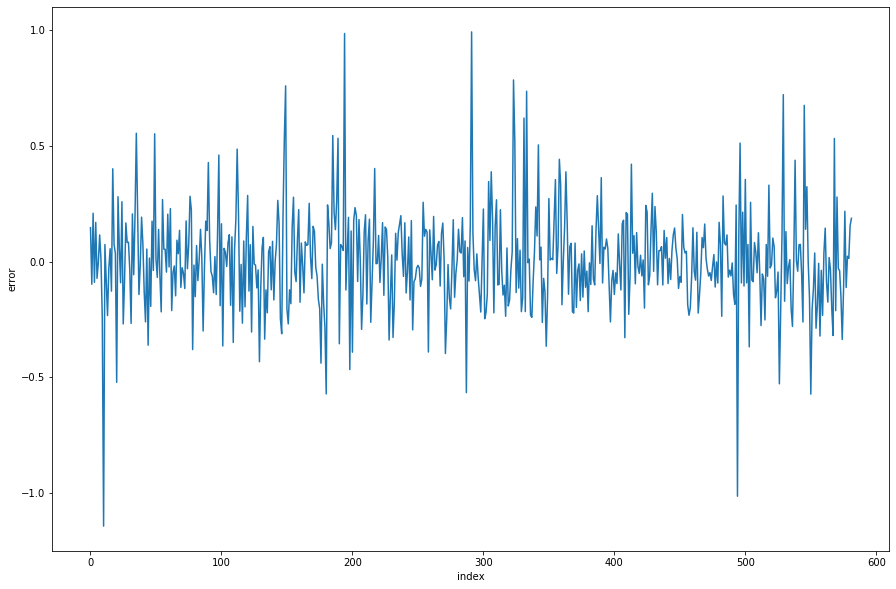

In [45]:
fig = plt.figure(figsize=(15,10))
sns.lineplot(data=df3,x='index',y='error')